In [1]:
# installing Kaggle library to import dataset
!pip install kaggle

In [2]:

import kagglehub
dataset_path = kagglehub.dataset_download('relufrank/fs2020-runway-dataset')
print(dataset_path)

Using Colab cache for faster access to the 'fs2020-runway-dataset' dataset.
/kaggle/input/fs2020-runway-dataset


In [3]:
!pip install imantics --quiet

In [4]:
base_path = "/kaggle/input/fs2020-runway-dataset"

train_images_path = base_path + "/1920x1080/1920x1080/train/"
train_masks_labels_path = base_path + "/labels/labels/areas/train_labels_1920x1080/"

test_images_path = base_path + "/1920x1080/1920x1080/test/"
test_masks_labels_path = base_path + "/labels/labels/areas/test_labels_1920x1080/"

print(train_images_path)
print(train_masks_labels_path)
print(test_images_path)
print(test_masks_labels_path)

/kaggle/input/fs2020-runway-dataset/1920x1080/1920x1080/train/
/kaggle/input/fs2020-runway-dataset/labels/labels/areas/train_labels_1920x1080/
/kaggle/input/fs2020-runway-dataset/1920x1080/1920x1080/test/
/kaggle/input/fs2020-runway-dataset/labels/labels/areas/test_labels_1920x1080/


In [5]:
import os

train_image_list = os.listdir(train_images_path)
train_image_labels_list = os.listdir(train_masks_labels_path)

test_image_list = os.listdir(test_images_path)
test_image_labels_list = os.listdir(test_masks_labels_path)
# no. of train images and labels
print(len(train_image_list))
print(len(train_image_labels_list))
print(len(test_image_list))
print(len(test_image_labels_list))

# name of the first image and label
print(train_image_list[0])
print(train_image_labels_list[0])
print(test_image_list[0])
print(test_image_labels_list[0])

image_size=512
input_image_size=(512,512)

3987
3987
1600
1600
PHNL08L5_4FNLImage1.png
PHNL08L5_4FNLImage1.png
EDDF07C1_3LDImage2.png
EDDF07C1_3LDImage2.png


In [6]:
import cv2
def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

array([[[52, 51, 58],
        [53, 52, 57],
        [53, 52, 57],
        ...,
        [53, 52, 57],
        [53, 52, 57],
        [53, 51, 59]],

       [[36, 35, 38],
        [36, 36, 36],
        [36, 36, 36],
        ...,
        [36, 36, 36],
        [36, 36, 36],
        [36, 35, 38]],

       [[36, 35, 38],
        [36, 36, 36],
        [36, 36, 36],
        ...,
        [36, 36, 36],
        [36, 36, 36],
        [36, 35, 38]],

       ...,

       [[37, 34, 21],
        [37, 34, 21],
        [36, 31, 19],
        ...,
        [32, 29, 16],
        [34, 31, 18],
        [33, 30, 20]],

       [[36, 31, 19],
        [35, 31, 19],
        [36, 33, 18],
        ...,
        [30, 25, 13],
        [29, 25, 15],
        [28, 25, 13]],

       [[37, 34, 21],
        [36, 33, 20],
        [38, 35, 22],
        ...,
        [29, 23, 14],
        [28, 24, 14],
        [28, 23, 14]]], dtype=uint8)
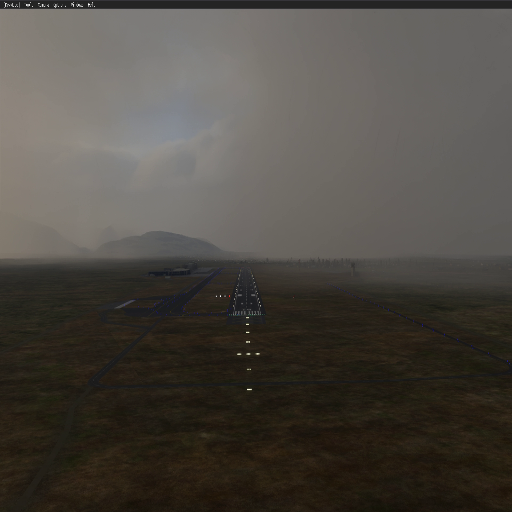

In [7]:
read_image(train_images_path + train_image_list[100])

In [8]:
def convert_to_mono_channel(img):
    # img = read_image(train_masks_labels_path + train_image_labels_list[100])
    grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    _ , mask = cv2.threshold(grey, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    img[mask!=0] = (255,0,0)
    return img, mask

img, mask = convert_to_mono_channel(read_image(train_masks_labels_path + train_image_labels_list[100]))

In [9]:
import numpy as np

def load_images(img_path, mask_path,image_list, amount):
    total_masks=np.zeros((1,image_size, image_size, 1), dtype=np.uint8)
    total_images=np.zeros((1,image_size, image_size, 3),dtype=np.uint8)

    for j,file in enumerate(image_list[0:amount]):   # trying with 100
        try:
            image = read_image(img_path + file)
            image_ex = np.expand_dims(image, axis=0)
            total_images = np.vstack([total_images, image_ex])

            mask = read_image(mask_path + file)
            _ , mask = convert_to_mono_channel(mask)
            mask = mask.reshape((512,512,1))
            mask_ex = np.expand_dims(mask, axis=0)
            total_masks = np.vstack([total_masks, mask_ex])

        except Exception as e:
            print(e)
            continue
    return total_images, total_masks

In [10]:
train_images, train_masks = load_images(train_images_path, train_masks_labels_path, train_image_list, len(train_image_list)//2)

In [11]:
test_images, test_masks = load_images(test_images_path, test_masks_labels_path, test_image_list, len(test_image_list)//2)

In [12]:
test_images.shape, train_images.shape

((801, 512, 512, 3), (1994, 512, 512, 3))

In [13]:
import tensorflow as tf

def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    return conv

def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv


def Unet_with_ResNet_encoder(input_shape=(512, 512, 3)):

    inputs = tf.keras.layers.Input(shape=input_shape)

    resnet_encoder = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs
    )

    skip1 = resnet_encoder.get_layer("conv1_relu").output         # 256x256
    skip2 = resnet_encoder.get_layer("conv2_block3_out").output  # 128x128
    skip3 = resnet_encoder.get_layer("conv3_block4_out").output  # 64x64
    skip4 = resnet_encoder.get_layer("conv4_block6_out").output   # 32x32

    bridge = resnet_encoder.get_layer("conv5_block3_out").output  # 16x16

    decode1 = decoder_block(bridge, skip4, 512)
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)

    up_final = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=2, padding="same")(decode4)
    conv_final = conv_block(up_final, 32)

    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(conv_final)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="ResNet_U-Net")
    return model

In [14]:

import tensorflow as tf
import keras.backend as K

def focal_loss(gamma=2.0, alpha=0.8):
    """
    Corrected Focal Loss for binary segmentation.
    """
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)

        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())

        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        bce = -alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1) \
              -(1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0)

        return tf.reduce_mean(bce)

    return focal_loss_fixed

def dice_loss(smooth=1):
    def dice_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        intersection = tf.reduce_sum(y_true * y_pred)
        union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

        dice = (2. * intersection + smooth) / (union + smooth)
        return 1. - dice
    return dice_loss_fixed

def dice_coefficient(smooth=1):
    def dice_metric(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        intersection = tf.reduce_sum(y_true * y_pred)
        union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

        return (2. * intersection + smooth) / (union + smooth)
    return dice_metric


def dice_focal_loss(gamma=2.0, alpha=0.8, smooth=1):

    focal = focal_loss(gamma, alpha)
    dice = dice_loss(smooth)
    def combined_loss(y_true, y_pred):
        return focal(y_true, y_pred) + dice(y_true, y_pred)
    return combined_loss



In [15]:
def get_callbacks():
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath="vgg19_unet_best_model.h5",
        monitor='val_dice_metric',  # Monitor the validation dice metric
        mode='max',                 # We want to maximize the dice coefficient
        save_best_only=True,
        verbose=1
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    return [model_checkpoint, reduce_lr, early_stopping]

In [16]:
import tensorflow as tf
tf.keras.mixed_precision.set_global_policy('float32')

resnet_unet_model = Unet_with_ResNet_encoder((512, 512, 3))

resnet_unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), # Start with a slightly lower learning rate
    loss=dice_focal_loss(),
    metrics=[dice_coefficient()])

resnet_unet_model.summary()


Model: "ResNet_U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 518, 518,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 256, 256,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 256, 256,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 256, 256,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 258, 258,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 128, 128,  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 128, 128,  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 128, 128,  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 128, 128,  │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 128, 128,  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 128, 128,  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 128, 128,  │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 128, 128,  │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 128, 128,  │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 128, 128,  │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 128, 128,  │      1,024 │ conv2_block1_3_c

 Total params: 41,004,609 (156.42 MB)

 Trainable params: 40,947,521 (156.20 MB)

 Non-trainable params: 57,088 (223.00 KB)

In [17]:
callbacks = get_callbacks()

history = resnet_unet_model.fit(
    train_images,
    train_masks,
    validation_split=0.2,
    batch_size=4,
    epochs=20,  # Set a high number, EarlyStopping will handle the rest
    callbacks=callbacks
)

Epoch 1/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - dice_metric: 1.5947 - loss: -0.5389
Epoch 1: val_dice_metric improved from -inf to 1.86789, saving model to vgg19_unet_best_model.h5


399/399 ━━━━━━━━━━━━━━━━━━━━ 378s 677ms/step - dice_metric: 1.5951 - loss: -0.5393 - val_dice_metric: 1.8679 - val_loss: -0.8139 - learning_rate: 1.0000e-04
Epoch 2/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - dice_metric: 1.8627 - loss: -0.8190
Epoch 2: val_dice_metric did not improve from 1.86789
399/399 ━━━━━━━━━━━━━━━━━━━━ 190s 477ms/step - dice_metric: 1.8627 - loss: -0.8189 - val_dice_metric: 1.8201 - val_loss: -0.8110 - learning_rate: 1.0000e-04
Epoch 3/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - dice_metric: 1.8871 - loss: -0.8572
Epoch 3: val_dice_metric improved from 1.86789 to 1.89797, saving model to vgg19_unet_best_model.h5


399/399 ━━━━━━━━━━━━━━━━━━━━ 213s 534ms/step - dice_metric: 1.8871 - loss: -0.8572 - val_dice_metric: 1.8980 - val_loss: -0.8784 - learning_rate: 1.0000e-04
Epoch 4/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - dice_metric: 1.9193 - loss: -0.9005
Epoch 4: val_dice_metric improved from 1.89797 to 1.90576, saving model to vgg19_unet_best_model.h5


399/399 ━━━━━━━━━━━━━━━━━━━━ 212s 531ms/step - dice_metric: 1.9193 - loss: -0.9005 - val_dice_metric: 1.9058 - val_loss: -0.8854 - learning_rate: 1.0000e-04
Epoch 5/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - dice_metric: 1.9277 - loss: -0.9099
Epoch 5: val_dice_metric did not improve from 1.90576
399/399 ━━━━━━━━━━━━━━━━━━━━ 190s 477ms/step - dice_metric: 1.9277 - loss: -0.9099 - val_dice_metric: 1.9010 - val_loss: -0.8907 - learning_rate: 1.0000e-04
Epoch 6/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - dice_metric: 1.9374 - loss: -0.9146
Epoch 6: val_dice_metric improved from 1.90576 to 1.90894, saving model to vgg19_unet_best_model.h5


399/399 ━━━━━━━━━━━━━━━━━━━━ 207s 519ms/step - dice_metric: 1.9374 - loss: -0.9145 - val_dice_metric: 1.9089 - val_loss: -0.8866 - learning_rate: 1.0000e-04
Epoch 7/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - dice_metric: 1.9170 - loss: -0.8917
Epoch 7: val_dice_metric improved from 1.90894 to 1.92401, saving model to vgg19_unet_best_model.h5


399/399 ━━━━━━━━━━━━━━━━━━━━ 205s 514ms/step - dice_metric: 1.9170 - loss: -0.8918 - val_dice_metric: 1.9240 - val_loss: -0.9137 - learning_rate: 1.0000e-04
Epoch 8/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - dice_metric: 1.9445 - loss: -0.9321
Epoch 8: val_dice_metric did not improve from 1.92401
399/399 ━━━━━━━━━━━━━━━━━━━━ 190s 476ms/step - dice_metric: 1.9444 - loss: -0.9321 - val_dice_metric: 1.8493 - val_loss: -0.8247 - learning_rate: 1.0000e-04
Epoch 9/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - dice_metric: 1.9391 - loss: -0.9196
Epoch 9: val_dice_metric improved from 1.92401 to 1.93669, saving model to vgg19_unet_best_model.h5


399/399 ━━━━━━━━━━━━━━━━━━━━ 205s 515ms/step - dice_metric: 1.9391 - loss: -0.9196 - val_dice_metric: 1.9367 - val_loss: -0.8943 - learning_rate: 1.0000e-04
Epoch 10/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - dice_metric: 1.9586 - loss: -0.9435
Epoch 10: val_dice_metric did not improve from 1.93669
399/399 ━━━━━━━━━━━━━━━━━━━━ 190s 476ms/step - dice_metric: 1.9586 - loss: -0.9435 - val_dice_metric: 1.9279 - val_loss: -0.9116 - learning_rate: 1.0000e-04
Epoch 11/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - dice_metric: 1.9526 - loss: -0.9354
Epoch 11: val_dice_metric did not improve from 1.93669
399/399 ━━━━━━━━━━━━━━━━━━━━ 190s 475ms/step - dice_metric: 1.9525 - loss: -0.9354 - val_dice_metric: 1.8527 - val_loss: -0.8462 - learning_rate: 1.0000e-04
Epoch 12/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - dice_metric: 1.9519 - loss: -0.9371
Epoch 12: val_dice_metric improved from 1.93669 to 1.95419, saving model to vgg19_unet_best_model.h5


399/399 ━━━━━━━━━━━━━━━━━━━━ 211s 528ms/step - dice_metric: 1.9520 - loss: -0.9372 - val_dice_metric: 1.9542 - val_loss: -0.9461 - learning_rate: 1.0000e-04
Epoch 13/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - dice_metric: 1.9624 - loss: -0.9472
Epoch 13: val_dice_metric did not improve from 1.95419
399/399 ━━━━━━━━━━━━━━━━━━━━ 190s 476ms/step - dice_metric: 1.9624 - loss: -0.9471 - val_dice_metric: 1.9164 - val_loss: -0.9074 - learning_rate: 1.0000e-04
Epoch 14/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - dice_metric: 1.9622 - loss: -0.9502
Epoch 14: val_dice_metric did not improve from 1.95419
399/399 ━━━━━━━━━━━━━━━━━━━━ 191s 478ms/step - dice_metric: 1.9622 - loss: -0.9502 - val_dice_metric: 1.9410 - val_loss: -0.9356 - learning_rate: 1.0000e-04
Epoch 15/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - dice_metric: 1.9681 - loss: -0.9579
Epoch 15: val_dice_metric improved from 1.95419 to 1.96436, saving model to vgg19_unet_best_model.h5


399/399 ━━━━━━━━━━━━━━━━━━━━ 212s 531ms/step - dice_metric: 1.9681 - loss: -0.9579 - val_dice_metric: 1.9644 - val_loss: -0.9465 - learning_rate: 1.0000e-04
Epoch 16/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - dice_metric: 1.9708 - loss: -0.9610
Epoch 16: val_dice_metric did not improve from 1.96436
399/399 ━━━━━━━━━━━━━━━━━━━━ 190s 476ms/step - dice_metric: 1.9708 - loss: -0.9610 - val_dice_metric: 1.9248 - val_loss: -0.9190 - learning_rate: 1.0000e-04
Epoch 17/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - dice_metric: 1.9747 - loss: -0.9651
Epoch 17: val_dice_metric did not improve from 1.96436
399/399 ━━━━━━━━━━━━━━━━━━━━ 190s 475ms/step - dice_metric: 1.9747 - loss: -0.9651 - val_dice_metric: 1.9331 - val_loss: -0.9261 - learning_rate: 1.0000e-04
Epoch 18/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - dice_metric: 1.9737 - loss: -0.9631
Epoch 18: val_dice_metric did not improve from 1.96436
399/399 ━━━━━━━━━━━━━━━━━━━━ 190s 475ms/step - dice_metric: 1.9737 - loss: -0.9630 - 

399/399 ━━━━━━━━━━━━━━━━━━━━ 210s 527ms/step - dice_metric: 1.9818 - loss: -0.9738 - val_dice_metric: 1.9763 - val_loss: -0.9642 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 20.


In [19]:
resnet_unet_model.save("working_model_0604.h5")

In [20]:
res_img = resnet_unet_model.predict(test_images)


26/26 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step


In [21]:
res_img.shape

(801, 512, 512, 1)

array([[[ 52,  51,  57],
        [ 53,  52,  57],
        [ 53,  52,  57],
        ...,
        [ 53,  52,  57],
        [ 53,  52,  57],
        [ 52,  51,  58]],

       [[ 36,  35,  37],
        [ 36,  36,  36],
        [ 36,  36,  36],
        ...,
        [ 36,  36,  36],
        [ 36,  36,  36],
        [ 36,  35,  37]],

       [[ 36,  35,  38],
        [ 36,  35,  38],
        [ 36,  36,  36],
        ...,
        [ 36,  36,  36],
        [ 36,  36,  36],
        [ 35,  34,  36]],

       ...,

       [[131, 114,  76],
        [134, 118,  76],
        [135, 117,  74],
        ...,
        [ 70,  65,  37],
        [ 54,  48,  25],
        [ 66,  64,  34]],

       [[134, 118,  76],
        [138, 120,  82],
        [132, 113,  74],
        ...,
        [ 37,  38,  28],
        [ 30,  32,  17],
        [ 35,  38,  19]],

       [[130, 113,  74],
        [125, 106,  70],
        [118, 101,  66],
        ...,
        [ 28,  31,  21],
        [ 46,  50,  22],
        [ 53,  57,  26]]], dtype=uint8)
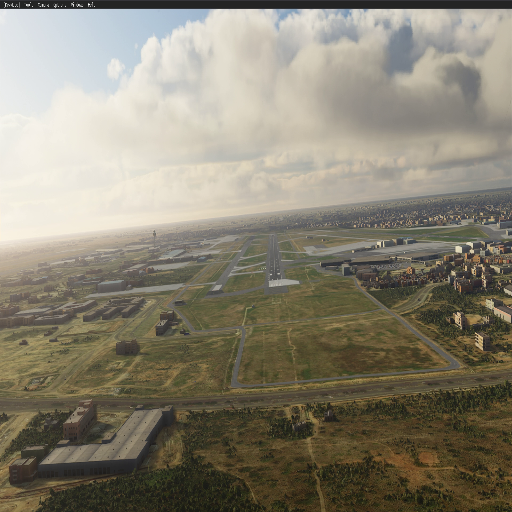

In [77]:
test_images[4]

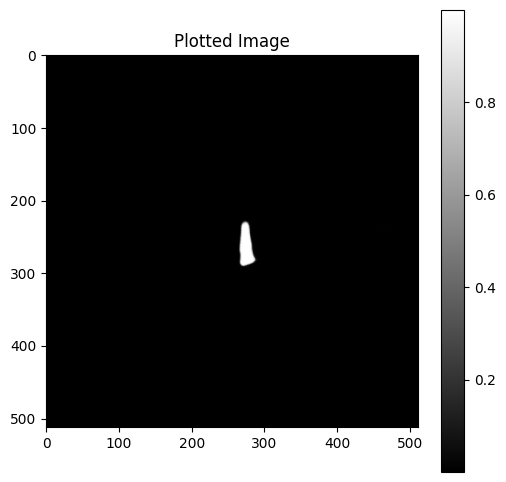

In [78]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

image_to_plot = res_img[4]

plt.figure(figsize=(6, 6))
plt.imshow(image_to_plot, cmap='gray')
plt.colorbar()
plt.title("Plotted Image")
plt.show()

In [37]:
def calculate_iou_numpy(y_true, y_pred, threshold=0.5):
    if y_pred.max() <= 1.0 and y_pred.min() >= 0.0:
        y_pred = (y_pred > threshold).astype(np.uint8)

    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)

    intersection = np.logical_and(y_true, y_pred)

    union = np.logical_or(y_true, y_pred)

    iou_score = np.sum(intersection) / np.sum(union)

    if np.sum(union) == 0:
        return 1.0

    return iou_score

In [38]:
avg = 0
for i in range((len(test_image_list)//2)-1):
  avg += calculate_iou_numpy(test_masks[i], res_img[i], 0.5)

avg / ((len(test_image_list)//2)-1)

/tmp/ipython-input-3596221056.py:12: RuntimeWarning: invalid value encountered in scalar divide
  iou_score = np.sum(intersection) / np.sum(union)


np.float64(0.5774907225118867)

In [40]:
import csv
def save_iou_to_csv(predicted_masks, ground_truth_masks, image_names, output_csv_path):

    if not (len(predicted_masks) == len(ground_truth_masks) == len(image_names)):
        raise ValueError("The number of masks and image names must be the same.")

    results = []

    for i in range(len(image_names)):
        pred_mask = predicted_masks[i]
        true_mask = ground_truth_masks[i]
        image_name = image_names[i]

        iou = calculate_iou_numpy(true_mask, pred_mask)

        results.append({'image_name': image_name, 'iou_score': iou})
        print(f"Calculated IoU for {image_name}: {iou:.4f}")

    if not results:
        print("No results to save.")
        return


    average_iou = np.mean([res['iou_score'] for res in results])

    try:
        with open(output_csv_path, 'w', newline='') as csvfile:
            fieldnames = ['image_name', 'iou_score']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

            writer.writeheader()
            writer.writerows(results)

    except IOError as e:
        print(f"\nError writing to file: {e}")


In [50]:
save_iou_to_csv(res_img, test_masks, os.listdir(test_images_path)[0:801], "IoU_CSV.csv")

/tmp/ipython-input-3596221056.py:12: RuntimeWarning: invalid value encountered in scalar divide
  iou_score = np.sum(intersection) / np.sum(union)


Calculated IoU for EDDF07C1_3LDImage2.png: 1.0000
Calculated IoU for VDSR05_1_5FNLImage2.png: 0.9441
Calculated IoU for LOWI08_1_7FNLImage1.png: 0.3000
Calculated IoU for VIDP28_1_3FNLImage3.png: 0.1182
Calculated IoU for EDDF36_1_4FNLImage6.png: 0.6141
Calculated IoU for LOWI08_1_8FNLImage2.png: 0.7138
Calculated IoU for LGAV03R1_3FNLImage4.png: 0.3262
Calculated IoU for KASE33_1_7FNLImage5.png: 0.4669
Calculated IoU for ETOU07_1_1LDImage3.png: 0.7318
Calculated IoU for VIDP10_2_9FNLImage3.png: 0.9555
Calculated IoU for EDDF25R1_4LDImage2.png: 0.1873
Calculated IoU for EDDF36_1_9LDImage2.png: 0.9751
Calculated IoU for NZQN23_1_5FNLImage6.png: 0.9494
Calculated IoU for VIDP28_1_3LDImage5.png: 0.5602
Calculated IoU for LFPG27L1_8FNLImage4.png: 0.8328
Calculated IoU for PHNL08L1_2FNLImage3.png: 0.5688
Calculated IoU for LOWI08_1_2FNLImage2.png: 0.3609
Calculated IoU for YSSY16L1_3LDImage3.png: 0.2886
Calculated IoU for LOWI26_1_9FNLImage3.png: 0.8457
Calculated IoU for EDDF25C1_8FNLImage

In [55]:
res_copy = res_img
test_copy = test_images

In [88]:
tf.expand_dims(res_copy[1], -1)
x1 = res_copy[1].shape[0]
x2 = res_copy[1].shape[1]
imgg = tf.reshape(tf.broadcast_to(res_copy[1], (x1, x2, 3)),  (x1, x2, 3))
overlayed = cv2.multiply((test_copy[1]).astype(np.float32), imgg.numpy().astype(np.float32))

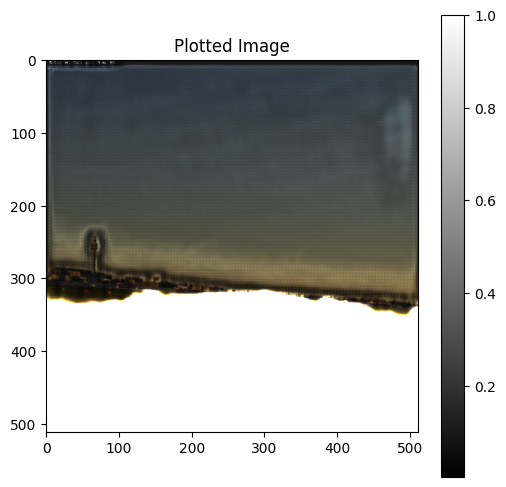

In [89]:
plt.figure(figsize=(6, 6))
plt.imshow(overlayed, cmap='gray')
plt.colorbar()
plt.title("Plotted Image")
plt.show()